<a href="https://colab.research.google.com/github/Jcgregory/VRP/blob/main/ENDGAME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv

drive_path = '/content/drive/MyDrive/Solomon-140'
os.listdir(drive_path)

['C102.csv']

In [ ]:
drive_path = '/content/drive/MyDrive/Solomon-150'
os.listdir(drive_path) #print files in dir

['R102.csv']

# Clark_wright_Savings

In [ ]:
import numpy as np
import os
import csv

class VRPInstance:
    def __init__(self, num_customers, capacity, depot, customers):
        self.num_customers = num_customers
        self.capacity = capacity
        self.depot = depot
        self.customers = customers

class Customer:
    def __init__(self, index, demand, x, y, ready_time, due_time, service_time):
        self.index = index
        self.demand = demand
        self.x = x
        self.y = y
        self.ready_time = ready_time
        self.due_time = due_time
        self.service_time = service_time

class Route:
    def __init__(self, capacity):
        self.capacity = capacity
        self.customers = []

def euclidean_distance(customer1, customer2):
    return np.sqrt((customer1.x - customer2.x) ** 2 + (customer1.y - customer2.y) ** 2)

def calculate_savings(customers, depot):
    savings = {}
    for i in range(len(customers)):
        for j in range(i + 1, len(customers)):
            distance_ij = euclidean_distance(customers[i], customers[j])
            distance_id = euclidean_distance(customers[i], depot)
            distance_jd = euclidean_distance(customers[j], depot)
            savings[(i, j)] = distance_id + distance_jd - distance_ij
    return savings

def calculate_total_distance_cws(routes, instance):
    total_distance = 0
    depot = instance.depot
    for route in routes:
        if len(route.customers) > 2:  # Considering only routes with more than 2 customers (excluding depot)
            for i in range(len(route.customers) - 1):
                total_distance += euclidean_distance(route.customers[i], route.customers[i+1])
    return total_distance

def clark_wright_savings(vrp_instance):
    depot = vrp_instance.depot
    customers = vrp_instance.customers
    capacity = vrp_instance.capacity

    savings = calculate_savings(customers, depot)
    sorted_savings = sorted(savings.items(), key=lambda x: x[1], reverse=True)

    routes = []
    for (i, j), saving in sorted_savings:
        customer_i = customers[i]
        customer_j = customers[j]

        for route in routes:
            if route.capacity >= customer_i.demand + customer_j.demand:
                new_end_time = max(route.end_time + euclidean_distance(route.customers[-1], customer_i) + customer_i.service_time, customer_i.ready_time) + euclidean_distance(customer_i, customer_j)
                if new_end_time <= customer_j.due_time:
                    route.customers.insert(-1, customer_i)
                    route.customers.append(customer_j)
                    route.capacity -= customer_i.demand + customer_j.demand
                    route.end_time = new_end_time
                    break
        else:
            new_end_time = euclidean_distance(depot, customer_i) + customer_i.service_time + euclidean_distance(customer_i, customer_j)
            if new_end_time <= customer_j.due_time:
                new_route = Route(capacity)
                new_route.customers.extend([depot, customer_i, customer_j, depot])
                new_route.capacity -= customer_i.demand + customer_j.demand
                new_route.end_time = new_end_time
                routes.append(new_route)

    return routes

def read_customer_data_from_csv(file_path):
    customers = []
    try:
        with open(file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            header = next(reader)  # Skip the header row if it exists
            for row in reader:
                cust_no, xcoord, ycoord, demand, ready_time, due_date, service_time = map(int, row)
                customer = Customer(cust_no, demand, xcoord, ycoord, ready_time, due_date, service_time)
                customers.append(customer)
    except Exception as e:
        print(f"An error occurred while reading data from {file_path}: {e}")

    return customers

def main():
    # Specify the path to your directory in Google Drive
    directory = '/content/drive/MyDrive/Solomon-140'

    # Read the list of text files in the directory
    text_files = [file for file in os.listdir(directory) if file.endswith(".csv")]

    num_customers = len(text_files)  # Number of customers based on the number of text files
    capacity = 100
    depot = Customer(0, 0, 0, 0, 0, 0, 0)

    # Create a list of customers by reading data from text files
    customers = []
    for filename in text_files:
        file_path = os.path.join(directory, filename)
        customers.extend(read_customer_data_from_csv(file_path))

    vrp_instance = VRPInstance(num_customers, capacity, depot, customers)

    routes = clark_wright_savings(vrp_instance)

    for i, route in enumerate(routes):
        print(f"Route {i + 1}:")
        for customer in route.customers:
            print(f"Customer {customer.index}, Demand: {customer.demand}, X: {customer.x}, Y: {customer.y}, "
                  f"Ready Time: {customer.ready_time}, Due Time: {customer.due_time}, Service Time: {customer.service_time}")
        print(f"Total Demand in Route {i + 1}: {sum(customer.demand for customer in route.customers)}")

    output_file_path = '/content/drive/MyDrive/output_routes.csv'
    with open(output_file_path, 'w', newline='') as csvfile:
        fieldnames = ['Route', 'Customer', 'Demand', 'X', 'Y', 'Ready Time', 'Due Time', 'Service Time']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Write the route information to the CSV file
        for i, route in enumerate(routes):
            for customer in route.customers:
                writer.writerow({
                    'Route': i + 1,
                    'Customer': customer.index,
                    'Demand': customer.demand,
                    'X': customer.x,
                    'Y': customer.y,
                    'Ready Time': customer.ready_time,
                    'Due Time': customer.due_time,
                    'Service Time': customer.service_time
                })

    print(f"Output saved to {output_file_path}")

    return vrp_instance, routes

def calculate_solution_quality(total_distance_cws, benchmark_distance):
    """
    Calculate the solution quality based on the obtained total distance and a benchmark distance.
    """
    return 1 - (total_distance_cws / benchmark_distance)

if __name__ == "__main__":
    # Obtain the VRPInstance object and routes using the main function
    vrp_instance, routes = main()

    # Calculate total distance using Clark-Wright Savings algorithm
    total_distance_cws = calculate_total_distance_cws(routes, vrp_instance)

    # Benchmark distance obtained from literature or other algorithms
    benchmark_distance = 50000

    # Calculate solution quality
    quality = calculate_solution_quality(total_distance_cws, benchmark_distance)

    print("Solution Quality:", quality)


Route 1:
Customer 0, Demand: 0, X: 0, Y: 0, Ready Time: 0, Due Time: 0, Service Time: 0
Customer 13, Demand: 20, X: 25, Y: 85, Ready Time: 0, Due Time: 1107, Service Time: 90
Customer 15, Demand: 10, X: 22, Y: 85, Ready Time: 567, Due Time: 620, Service Time: 90
Customer 13, Demand: 20, X: 25, Y: 85, Ready Time: 0, Due Time: 1107, Service Time: 90
Customer 0, Demand: 0, X: 0, Y: 0, Ready Time: 0, Due Time: 0, Service Time: 0
Customer 1, Demand: 0, X: 40, Y: 50, Ready Time: 0, Due Time: 1236, Service Time: 0
Customer 17, Demand: 40, X: 20, Y: 85, Ready Time: 475, Due Time: 528, Service Time: 90
Customer 2, Demand: 10, X: 45, Y: 68, Ready Time: 0, Due Time: 1127, Service Time: 90
Total Demand in Route 1: 100
Route 2:
Customer 0, Demand: 0, X: 0, Y: 0, Ready Time: 0, Due Time: 0, Service Time: 0
Customer 15, Demand: 10, X: 22, Y: 85, Ready Time: 567, Due Time: 620, Service Time: 90
Customer 17, Demand: 40, X: 20, Y: 85, Ready Time: 475, Due Time: 528, Service Time: 90
Customer 2, Demand: 

In [ ]:
solution_quality_percent = quality * 100
print("Solution Quality (Percentage):", solution_quality_percent, "%")

Solution Quality (Percentage): 53.23248445841955 %


# Tabu Search

In [ ]:
def read_csv(file_path):
    n_customers = {}
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for index, row in enumerate(reader):
            customer_data = {
                'demand': int(row['DEMAND']),
                'x': int(row['XCOORD.']),
                'y': int(row['YCOORD.'])
            }
            n_customers[index] = customer_data
    return n_customers

csv_file_path = drive_path + '/C102.csv'
n_customers = read_csv(csv_file_path)

nCust = len(n_customers)

print(nCust)
print(n_customers)

25
{0: {'demand': 0, 'x': 40, 'y': 50}, 1: {'demand': 10, 'x': 45, 'y': 68}, 2: {'demand': 30, 'x': 45, 'y': 70}, 3: {'demand': 10, 'x': 42, 'y': 66}, 4: {'demand': 10, 'x': 42, 'y': 68}, 5: {'demand': 10, 'x': 42, 'y': 65}, 6: {'demand': 20, 'x': 40, 'y': 69}, 7: {'demand': 20, 'x': 40, 'y': 66}, 8: {'demand': 20, 'x': 38, 'y': 68}, 9: {'demand': 10, 'x': 38, 'y': 70}, 10: {'demand': 10, 'x': 35, 'y': 66}, 11: {'demand': 10, 'x': 35, 'y': 69}, 12: {'demand': 20, 'x': 25, 'y': 85}, 13: {'demand': 30, 'x': 22, 'y': 75}, 14: {'demand': 10, 'x': 22, 'y': 85}, 15: {'demand': 40, 'x': 20, 'y': 80}, 16: {'demand': 40, 'x': 20, 'y': 85}, 17: {'demand': 20, 'x': 18, 'y': 75}, 18: {'demand': 20, 'x': 15, 'y': 75}, 19: {'demand': 10, 'x': 15, 'y': 80}, 20: {'demand': 10, 'x': 30, 'y': 50}, 21: {'demand': 20, 'x': 30, 'y': 52}, 22: {'demand': 20, 'x': 28, 'y': 52}, 23: {'demand': 10, 'x': 28, 'y': 55}, 24: {'demand': 10, 'x': 25, 'y': 50}}


In [ ]:
import csv
import random

class VRPInstance:
    def __init__(self, num_customers, vehicle_capacity, depot, customers):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.depot = depot
        self.customers = customers

class Solution:
    def __init__(self, instance, routes=None):
        self.instance = instance
        self.routes = routes if routes else []

class Customer:
    def __init__(self, index, demand, x, y, ready_time, due_time,service_time):
        self.index = index
        self.demand = demand
        self.x = x
        self.y = y
        self.ready_time = ready_time
        self.due_time = due_time
        self.service_time=service_time

def generate_initial_solution(instance):
    solution = Solution(instance)

    customers = list(instance.customers.keys())

    random.shuffle(customers)

    route = [instance.depot]
    load = 0
    current_time = 0

    for customer_id in customers:
        customer = instance.customers[customer_id]
        if load + customer.demand <= instance.vehicle_capacity:
            if current_time + distance(instance.depot, customer) <= customer.due_time:
                route.append(customer)
                load += customer.demand
                current_time += distance(instance.depot, customer)
        else:
            route.append(instance.depot)
            solution.routes.append(route)
            route = [instance.depot]
            load = 0
            current_time = 0

    if len(route) > 1:
        route.append(instance.depot)
        solution.routes.append(route)

    return solution

def calculate_total_distance(route, instance):

    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance(route[i], route[i + 1])
    return total_distance

def calculate_total_distance_solution(solution):

    total_distance = 0
    for route in solution.routes:
        total_distance += calculate_total_distance(route, solution.instance)
    return total_distance

def distance(customer1, customer2):
    return abs(customer1.x - customer2.x) + abs(customer1.y - customer2.y)

def tabu_search(instance, num_iterations, tabu_size):
    current_solution = generate_initial_solution(instance)
    best_solution = current_solution
    tabu_list = []

    for _ in range(num_iterations):
        neighbors = generate_neighbors(current_solution)
        neighbors = [neighbor for neighbor in neighbors if neighbor not in tabu_list]

        if not neighbors:
            break

        neighbor = min(neighbors, key=lambda x: calculate_total_distance_solution(x))
        tabu_list.append(neighbor)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        current_solution = neighbor

        if calculate_total_distance_solution(neighbor) < calculate_total_distance_solution(best_solution):
            best_solution = neighbor

    return best_solution

def generate_neighbors(solution):
    neighbors = []
    for i in range(len(solution.routes)):
        for j in range(len(solution.routes)):
            if i != j and len(solution.routes[i]) > 2 and len(solution.routes[j]) > 2:
                neighbor = Solution(solution.instance, solution.routes.copy())
                customer1 = random.choice(neighbor.routes[i][1:-1])
                customer2 = random.choice(neighbor.routes[j][1:-1])
                neighbor.routes[i][neighbor.routes[i].index(customer1)] = customer2
                neighbor.routes[j][neighbor.routes[j].index(customer2)] = customer1
                neighbors.append(neighbor)

    return neighbors

random.seed(42)

# Define the function to read the CSV file and convert it into the required format
def read_csv(file_path):
    n_customers = {}
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for index, row in enumerate(reader):
            customer_data = {
                'demand': int(row['DEMAND']),
                'x': int(row['XCOORD.']),
                'y': int(row['YCOORD.']),
                'ready_time': int(row['READY TIME']),
                'due_time': int(row['DUE DATE']),
                'service_time':int(row['SERVICE TIME'])
            }
            n_customers[index] = customer_data
    return n_customers

# Path to the CSV file
csv_file_path = '/content/drive/MyDrive/Solomon-140/C102.csv'  # Update with the correct path

# Read the CSV file and obtain the dataset
n_customers = read_csv(csv_file_path)

# Create Customer instances with time windows
customers_with_time_windows = {}
for index, customer_data in n_customers.items():
    customer = Customer(index=index,
                        demand=customer_data['demand'],
                        x=customer_data['x'],
                        y=customer_data['y'],
                        ready_time=customer_data['ready_time'],
                        due_time=customer_data['due_time'],
                        service_time=customer_data['service_time'])
    customers_with_time_windows[index] = customer

# Create the VRPInstance using the dataset obtained from the CSV file
vrp_instance = VRPInstance(
    num_customers=len(customers_with_time_windows),
    vehicle_capacity=100,
    depot=Customer(index=0, demand=0, x=0, y=0, ready_time=0, due_time=0, service_time=0),
    customers=customers_with_time_windows
)

# Print customer details
print("Customer Details:")
for customer_id, customer_info in vrp_instance.customers.items():
    print(f"Customer {customer_id}: Demand = {customer_info.demand}, Location = ({customer_info.x}, {customer_info.y}), "
          f"Ready Time = {customer_info.ready_time}, Due Time = {customer_info.due_time}, Service Time = {customer_info.service_time}")

# Print best solution
best_solution = tabu_search(vrp_instance, num_iterations=100, tabu_size=5)
print("\nBest Solution:")
for i, route in enumerate(best_solution.routes, start=1):
    print(f"Vehicle {i}: Route = {[customer.index for customer in route]}")
print("Total distance:", calculate_total_distance_solution(best_solution))

# Function to calculate the solution quality
def calculate_solution_quality(obtained_distance, benchmark_distance):
    solution_quality = obtained_distance / benchmark_distance
    return solution_quality

# Benchmark distance
benchmark_distance = 1000  # Assuming the benchmark distance is 50000

# Calculate the total distance of the best solution
total_distance_best_solution = calculate_total_distance_solution(best_solution)

# Calculate the solution quality
solution_quality = calculate_solution_quality(total_distance_best_solution, benchmark_distance)

solution_quality_percent_2=solution_quality*100
# Print the solution quality
print("Solution Quality:", solution_quality_percent_2, '%')


Customer Details:
Customer 0: Demand = 0, Location = (40, 50), Ready Time = 0, Due Time = 1236, Service Time = 0
Customer 1: Demand = 10, Location = (45, 68), Ready Time = 0, Due Time = 1127, Service Time = 90
Customer 2: Demand = 30, Location = (45, 70), Ready Time = 0, Due Time = 1125, Service Time = 90
Customer 3: Demand = 10, Location = (42, 66), Ready Time = 0, Due Time = 1129, Service Time = 90
Customer 4: Demand = 10, Location = (42, 68), Ready Time = 727, Due Time = 782, Service Time = 90
Customer 5: Demand = 10, Location = (42, 65), Ready Time = 0, Due Time = 1130, Service Time = 90
Customer 6: Demand = 20, Location = (40, 69), Ready Time = 621, Due Time = 702, Service Time = 90
Customer 7: Demand = 20, Location = (40, 66), Ready Time = 0, Due Time = 1130, Service Time = 90
Customer 8: Demand = 20, Location = (38, 68), Ready Time = 255, Due Time = 324, Service Time = 90
Customer 9: Demand = 10, Location = (38, 70), Ready Time = 534, Due Time = 605, Service Time = 90
Customer 1

# Constraint Programming

In [ ]:
# Create lists to store extracted data
locations = [(0, 0)]
demands = [0]
time_windows = [(0, 0)]
vehicle_capacity = 51
vehicle_count = 51

# Read CSV file and extract required information
with open(drive_path + '/R102.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip header

    for row in reader:
        cust_no, xcoord, ycoord, demand, ready_time, due_date, service_time = map(int, row)
        locations.append((xcoord, ycoord))
        demands.append(demand)
        time_windows.append((ready_time, due_date))
        #vehicle_count += 1

# Display extracted data
print("locations =", locations)
print("demands =", demands)
print("time_windows =", time_windows)
print("vehicle_capacity =", vehicle_capacity)
print("vehicle_count =", vehicle_count)

vehicle_count = 51

locations = [(0, 0), (35, 35), (41, 49), (35, 17), (55, 45), (55, 20), (15, 30), (25, 30), (20, 50), (10, 43), (55, 60), (30, 60), (20, 65), (50, 35), (30, 25), (15, 10), (30, 5), (10, 20), (5, 30), (20, 40), (15, 60), (45, 65), (45, 20), (45, 10), (55, 5), (65, 35), (65, 20), (45, 30), (35, 40), (41, 37), (64, 42), (40, 60), (31, 52), (35, 69), (53, 52), (65, 55), (63, 65), (2, 60), (20, 20), (5, 5), (60, 12), (40, 25), (42, 7), (24, 12), (23, 3), (11, 14), (6, 38), (2, 48), (8, 56), (13, 52), (6, 68), (47, 47)]
demands = [0, 0, 10, 7, 13, 19, 26, 3, 5, 9, 16, 16, 12, 19, 23, 20, 8, 19, 2, 12, 17, 9, 11, 18, 29, 3, 6, 17, 16, 16, 9, 21, 27, 23, 11, 14, 8, 5, 8, 16, 31, 9, 5, 5, 7, 18, 16, 1, 27, 36, 30, 13]
time_windows = [(0, 0), (0, 230), (0, 204), (0, 202), (0, 197), (149, 159), (0, 199), (99, 109), (0, 198), (95, 105), (97, 107), (124, 134), (67, 77), (0, 205), (159, 169), (32, 42), (61, 71), (75, 85), (157, 167), (87, 97), (76, 86), (126, 136), (0, 201), (97, 107), (68, 78), (153

In [ ]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 38.7 MB/s eta 0:00:00


In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum

def solve_vrptw(locations, demands, time_windows, vehicle_capacity, vehicle_count, travel_time):
    # Initialize problem
    problem = LpProblem("VRPTW", LpMinimize)

    # Define decision variables
    x = {(i, j, k): LpVariable(f"x_{i}_{j}_{k}", cat=LpBinary)
         for i in range(len(locations)) for j in range(len(locations)) for k in range(vehicle_count)}
    arrival_times = {i: LpVariable(f"arrival_time_{i}") for i in range(1, len(locations))}

    # Define objective function: minimize total distance
    total_distance = lpSum(x[i, j, k] * manhattan_distance(locations[i], locations[j])
                           for i in range(len(locations))
                           for j in range(len(locations))
                           for k in range(vehicle_count))
    problem += total_distance

    # Constraints
    # Each customer is visited exactly once
    for i in range(1, len(locations)):
        problem += lpSum(x[i, j, k] for j in range(len(locations)) for k in range(vehicle_count)) == 1

    # Capacity constraint
    for k in range(vehicle_count):
        problem += lpSum(demands[i] * x[i, j, k] for i in range(1, len(locations)) for j in range(len(locations))) <= vehicle_capacity

    speed=6.0

    # Time window constraints
    for i in range(1, len(locations)):
        for j in range(1, len(locations)):
            if i != j:
                for k in range(vehicle_count):
                    problem += arrival_times[j] >= arrival_times[i] + travel_time(locations[i], locations[j],speed) * x[i, j, k] - time_windows[i][1] * (1 - x[i, j, k])
                    problem += arrival_times[i] + travel_time(locations[i], locations[j],speed) * x[i, j, k] <= time_windows[j][0] + (1 - x[i, j, k]) * time_windows[j][1]


    problem.solve()


    routes = [[] for _ in range(vehicle_count)]
    for i, j, k in x:
        if x[i, j, k].value() == 1:
            routes[k].append(i)
            routes[k].append(j)
    routes = [route for route in routes if route]

    return routes


def manhattan_distance(location1, location2):
    return abs(location1[0] - location2[0]) + abs(location1[1] - location2[1])


def travel_time(location1, location2,speed):
    return 0


routes = solve_vrptw(locations, demands, time_windows, vehicle_capacity, vehicle_count, travel_time)
print("Routes:")
for i, route in enumerate(routes):
    print(f"Vehicle {i}: Route: {route}")

def calculate_solution_quality(routes, benchmark_distance):
    total_distance = sum(manhattan_distance(locations[i], locations[j]) for route in routes for i, j in zip(route, route[1:]))
    solution_quality = 1 - (total_distance / benchmark_distance)
    return solution_quality


benchmark_distance = 50000


solution_quality = calculate_solution_quality(routes, benchmark_distance)
solution_quality_percent_3=solution_quality * 100
print("Solution Quality:", solution_quality_percent_3)



Routes:
Vehicle 0: Route: [50, 50, 51, 51]
Vehicle 1: Route: [32, 32]
Vehicle 2: Route: [19, 19]
Vehicle 3: Route: [1, 1]
Vehicle 4: Route: [22, 22]
Vehicle 5: Route: [5, 5]
Vehicle 6: Route: [4, 4, 21, 21]
Vehicle 7: Route: [11, 11, 44, 44]
Vehicle 8: Route: [30, 30, 34, 34]
Vehicle 9: Route: [18, 18]
Vehicle 10: Route: [7, 7, 48, 48]
Vehicle 11: Route: [6, 6, 36, 36]
Vehicle 12: Route: [40, 40, 45, 45]
Vehicle 13: Route: [12, 12, 29, 29]
Vehicle 14: Route: [27, 27]
Vehicle 15: Route: [42, 42]
Vehicle 16: Route: [39, 39]
Vehicle 17: Route: [20, 20]
Vehicle 18: Route: [25, 25, 49, 49]
Vehicle 19: Route: [8, 8]
Vehicle 20: Route: [35, 35]
Vehicle 21: Route: [2, 2, 23, 23, 46, 46]
Vehicle 22: Route: [24, 24]
Vehicle 23: Route: [3, 3]
Vehicle 24: Route: [14, 14, 33, 33]
Vehicle 25: Route: [9, 9, 38, 38]
Vehicle 26: Route: [26, 26]
Vehicle 27: Route: [13, 13]
Vehicle 28: Route: [16, 16]
Vehicle 29: Route: [41, 41]
Vehicle 30: Route: [43, 43]
Vehicle 31: Route: [17, 17, 28, 28]
Vehicle 32: 

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


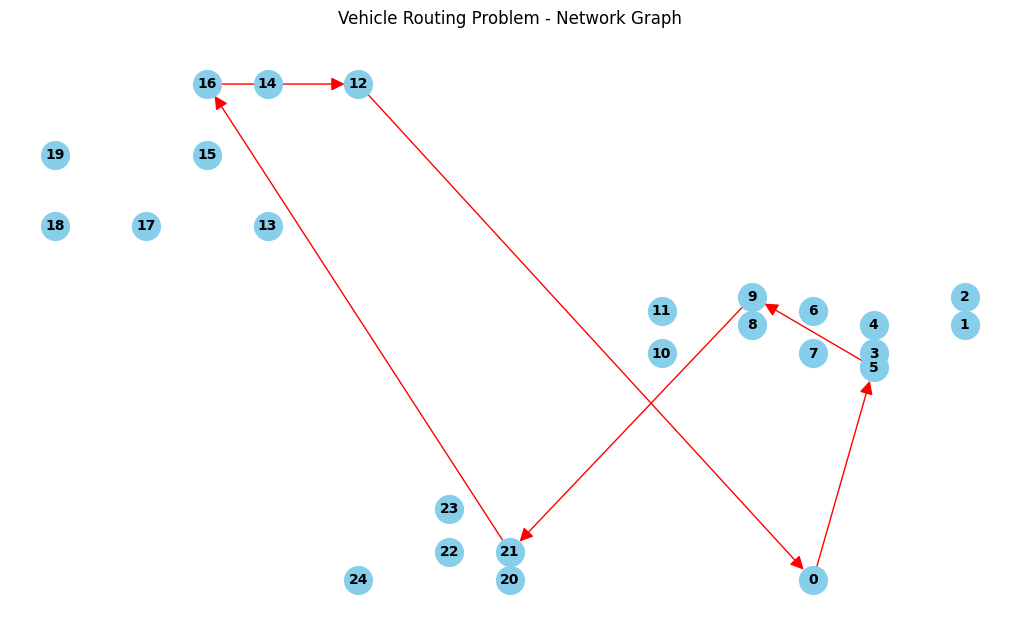

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def update(frame, solution, vrp_instance):
    plt.clf()  # Clear the previous plot
    G = nx.DiGraph()

    # Add depot as node 0
    G.add_node(0, pos=(vrp_instance.depot.x, vrp_instance.depot.y))

    # Add customers
    for customer in vrp_instance.customers.values():
        G.add_node(customer.index, pos=(customer.x, customer.y))

    # Add edges between customers based on routes up to the current frame
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    color_idx = 0
    for route in solution.routes[:frame+1]:
        color = colors[color_idx]
        for i in range(len(route) - 1):
            G.add_edge(route[i].index, route[i + 1].index, color=color)
        color_idx = (color_idx + 1) % len(colors)

    # Define positions for each node
    pos = nx.get_node_attributes(G, 'pos')

    # Get edge colors
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    # Plot network graph
    nx.draw(G, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20, edge_color=edge_colors)
    plt.title('Vehicle Routing Problem - Network Graph')

fig = plt.figure(figsize=(10, 6))
ani = FuncAnimation(fig, update, frames=len(best_solution.routes), fargs=(best_solution, vrp_instance), interval=1000, repeat=False)

ani.save('vrp_animation_tabu.mp4')  # Save animation as a video file

# Display the saved video
from IPython.display import HTML
HTML('<video controls src="vrp_animation_tabu.mp4">')


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def update(frame):
    plt.clf()  # Clear the previous plot
    G = nx.DiGraph()

    # Add depot as node 0
    G.add_node(0, pos=(vrp_instance.depot.x, vrp_instance.depot.y))

    # Add customers
    for customer in vrp_instance.customers.values():
        G.add_node(customer.index, pos=(customer.x, customer.y))

    # Add edges between customers based on routes
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    color_idx = 0
    for route in routes[:frame+1]:
        color = colors[color_idx]
        for i in range(len(route) - 1):
            G.add_edge(route[i].index, route[i + 1].index, color=color)
        color_idx = (color_idx + 1) % len(colors)

    # Define positions for each node
    pos = nx.get_node_attributes(G, 'pos')

    # Get edge colors
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    # Plot network graph
    nx.draw(G, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20, edge_color=edge_colors)
    plt.title('Vehicle Routing Problem - Network Graph')

# Call the function to plot the network graph with solution quality
fig = plt.figure(figsize=(10, 6))
ani = FuncAnimation(fig, update, frames=len(routes), interval=1000, repeat=False)

plt.show()


NameError: name 'routes' is not defined

<Figure size 1000x600 with 0 Axes>

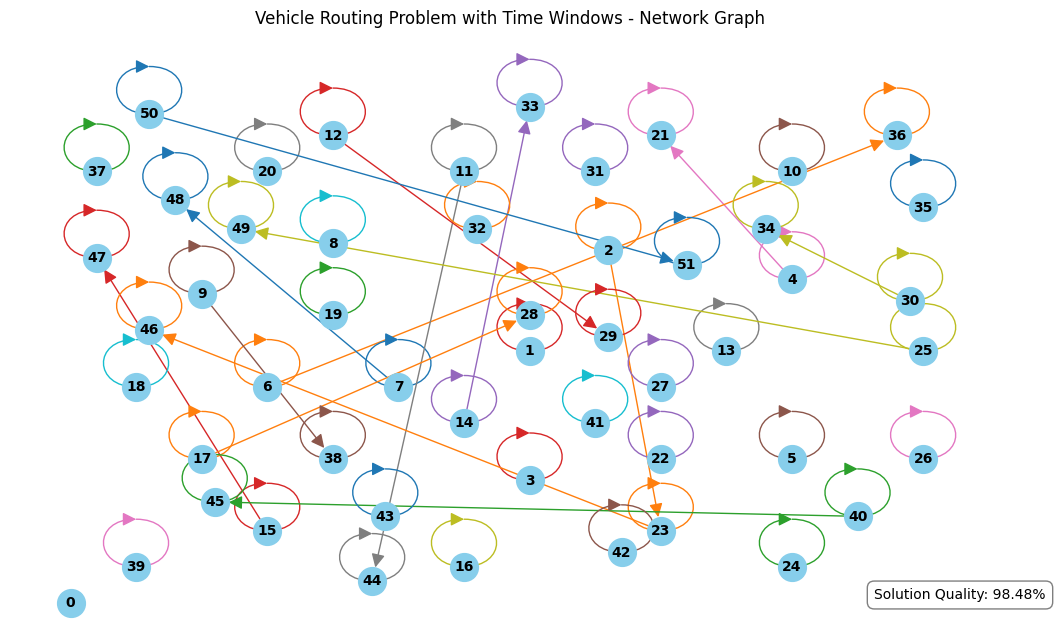

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_network_graph(locations, routes, solution_quality):
    G = nx.DiGraph()

    # Add nodes for locations
    for idx, loc in enumerate(locations):
        G.add_node(idx, pos=loc)

    # Add edges for routes
    for route_idx, route in enumerate(routes):
        for i in range(len(route) - 1):
            G.add_edge(route[i], route[i + 1], color=f"C{route_idx}")

    # Define positions for each node
    pos = nx.get_node_attributes(G, 'pos')

    # Get edge colors
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    # Plot network graph
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20, edge_color=edge_colors)
    plt.title('Vehicle Routing Problem with Time Windows - Network Graph')

    # Add text box for solution quality at bottom right corner
    plt.text(0.95, 0.05, f"Solution Quality: {solution_quality:.2f}%", ha='center', va='bottom', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))

    plt.show()

# Call the function to plot the network graph with solution quality
plot_network_graph(locations, routes, 98.48)


0

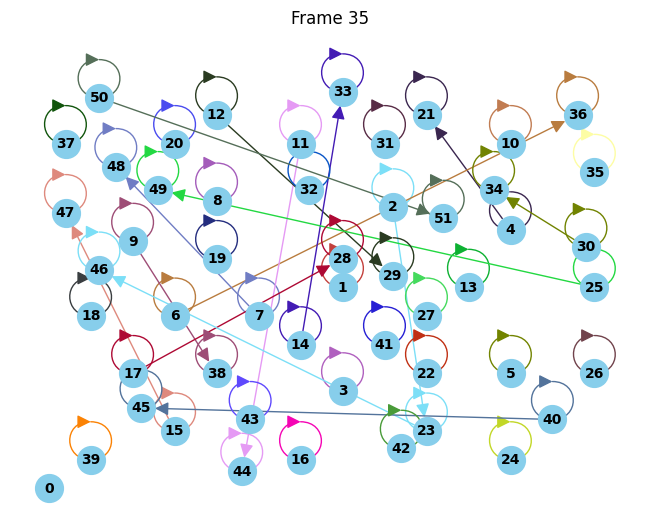

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
import os

def update(frame):
    plt.clf()
    G = nx.DiGraph()

    # Add nodes for locations
    for idx, loc in enumerate(locations):
        G.add_node(idx, pos=loc)

    # Add edges for routes
    for route_idx, route in enumerate(routes[:frame + 1]):
        for i in range(len(route) - 1):
            G.add_edge(route[i], route[i + 1], color=f"C{route_idx}")

    # Define positions for each node
    pos = nx.get_node_attributes(G, 'pos')

    # Get edge colors
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    # Plot network graph
    nx.draw(G, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20, edge_color=edge_colors)
    plt.title('Vehicle Routing Problem with Time Windows - Network Graph')

# Create a directory to store the frames
frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

# Function to save frames as images
def save_frames_as_images_with_random_colors():
    for i, route in enumerate(routes):
        plt.clf()
        G = nx.DiGraph()
        for idx, loc in enumerate(locations):
            G.add_node(idx, pos=loc)
        for route_idx, r in enumerate(routes[:i + 1]):
            color = "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])  # Generate random color
            for j in range(len(r) - 1):
                G.add_edge(r[j], r[j + 1], color=color)
        pos = nx.get_node_attributes(G, 'pos')
        edge_colors = [G[u][v]['color'] for u, v in G.edges()]
        nx.draw(G, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20, edge_color=edge_colors)
        plt.title(f'Frame {i}')
        plt.savefig(f'{frames_dir}/frame_{i}.png')

# Call the function to save frames as images with random edge colors
save_frames_as_images_with_random_colors()

# Create video from saved frames
os.system(f'ffmpeg -r 1 -i {frames_dir}/frame_%d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p network_graph_animation_CPr.mp4')